# Table of Contents
 <p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import epistasis as epi
import numba 
from matplotlib import rc
import tissue_enrichment_analysis as ea

import os
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})


%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
strains =['PS4187', 'PS4087', 'PS4176']

strain_dict = {}
for i, g in enumerate(strains):
    strain_dict[g] = i

In [3]:
q = 0.1

In [4]:
genmap = pd.read_csv('../sleuth/rna_seq_info.txt', sep=' ', comment='#')
tidy  = pd.read_csv('../input/quantifications.csv')

tidy = tidy[tidy.strain.isin(strains)]

In [5]:
overlap_sy622_het = epi.find_overlap(['PS4087', 'PS4176'], tidy, q=q)
overlap_bx93_het = epi.find_overlap(['PS4187', 'PS4176'], tidy, q=q)
overlap_sy622_bx93 = epi.find_overlap(['PS4187', 'PS4087'], tidy, q=q)

In [6]:
sy622_associated = tidy[tidy.target_id.isin(overlap_sy622_het) & (~tidy.target_id.isin(overlap_sy622_bx93))].target_id.unique()
bx93_associated = tidy[tidy.target_id.isin(overlap_bx93_het) | (tidy.target_id.isin(overlap_sy622_bx93))].target_id.unique()
# bx93_associated = tidy[tidy.target_id.isin(overlap_bx93_het)].target_id.unique()

bx93_specific = tidy[(~tidy.target_id.isin(overlap_sy622_bx93)) & (~tidy.target_id.isin(overlap_bx93_het)) & (tidy.qval < q) &
                     (tidy.strain == 'PS4187')].target_id.unique()

sy622_specific = tidy[(~tidy.target_id.isin(overlap_sy622_bx93)) & (~tidy.target_id.isin(overlap_sy622_het)) & (tidy.qval < q) &
                      (tidy.strain == 'PS4087')].target_id.unique()

transhet_specific = tidy[(~tidy.target_id.isin(overlap_bx93_het)) & (~tidy.target_id.isin(overlap_sy622_het)) & (tidy.qval < q)
                         & (tidy.strain == 'PS4176')].target_id.unique()


classes = {'sy622 associated': sy622_associated,
           'bx93 associated': bx93_associated,
           'sy622 specific': sy622_specific,
           'bx93 specific': bx93_specific,
           'transhet specific': transhet_specific}

In [7]:
inv_classes = {}

for key, value in classes.items():
    n = len(tidy[tidy.target_id.isin(value)].ens_gene.unique())
    print(key, n)
    
    for v in value:
        inv_classes[v] = key

sy622 associated 720
transhet specific 1226
bx93 specific 78
sy622 specific 1841
bx93 associated 403


In [8]:
tidy['phenotypic class'] = tidy.target_id.map(inv_classes)

bx93 associated mean: 1.2, median: 0.87
bx93 associated 95 percentile: 3.2
sy622 associated mean: 0.91, median: 0.55
sy622 associated 95 percentile: 2.9
sy622 specific mean: 0.88, median: 0.52
sy622 specific 95 percentile: 3


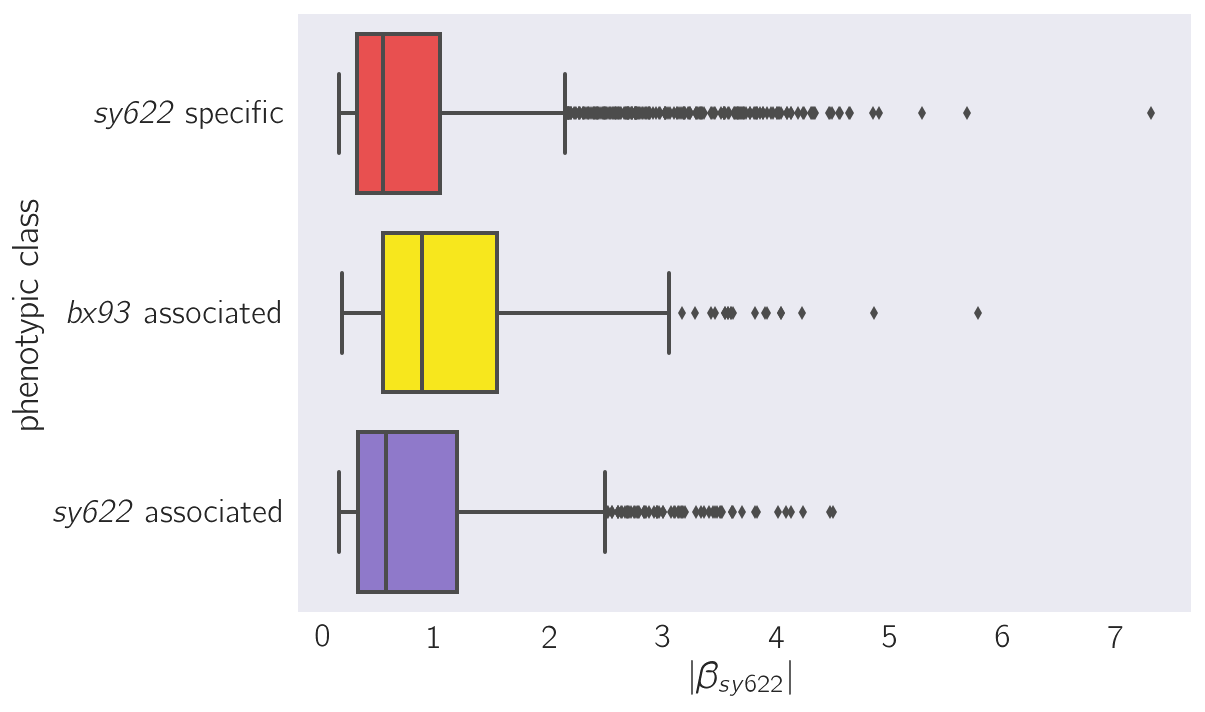

In [9]:
temp = tidy[(tidy.qval < q) & (tidy.strain == 'PS4087')].dropna().copy()
temp.b = temp.b.abs()
sns.boxplot(y='phenotypic class', x='b', data=temp)
plt.xlabel(r'$|\beta_{sy622}|$')
plt.gca().set_yticklabels([r'\emph{sy622} specific', r'\emph{bx93} associated', r'\emph{sy622} associated'])

plt.gca().artists[0].set_facecolor('#E85050')
plt.gca().artists[1].set_facecolor('#F7E71D')
plt.gca().artists[2].set_facecolor('#8F79CA')
plt.savefig('../output/beta_values_phenotypic_classes_sy622.svg', bbox_inches='tight')

grouped = temp.groupby('phenotypic class')
for name, group in grouped:
    print("{0} mean: {1:.2g}, median: {2:.2g}".format(name, group.b.mean(), np.median(group.b)))
    print("{0} 95 percentile: {1:.2g}".format(name, group.b.quantile(.95)))

In [10]:
def bootstrap_difference_of_statistic(x, y, n=10**4, statistic=np.mean):
    """Given two datasets, return a pvalue for null H (means are the same)."""
    nx = len(x)
    ny = len(y)
    mixed = np.zeros(nx + ny)
    mixed[0:nx] = x
    mixed[nx:] = y


    @numba.jit(nopython=True)
    def bootstrap(mixed, nx, ny, n):
        delta = np.zeros(n)
        for i in np.arange(n):
            nullx = np.random.choice(mixed, nx, replace=True)
            nully = np.random.choice(mixed, ny, replace=True)
            diff = statistic(nully) - statistic(nullx)
            delta[i] = diff
        return delta

    delta = bootstrap(mixed, nx, ny, n)
    return delta

def significance(pval, alpha, x, y):
    if pval < alpha:
        print('The medians between {0} and {1} are statistically significantly different.'.format(x, y))
    else:
        print('The medians between {0} and {1} are NOT statistically significantly different.'.format(x, y))
    print('pvalue is {0:.2g}'.format(pval))

The medians between bx93 associated and sy622 associated are statistically significantly different.
pvalue is 0


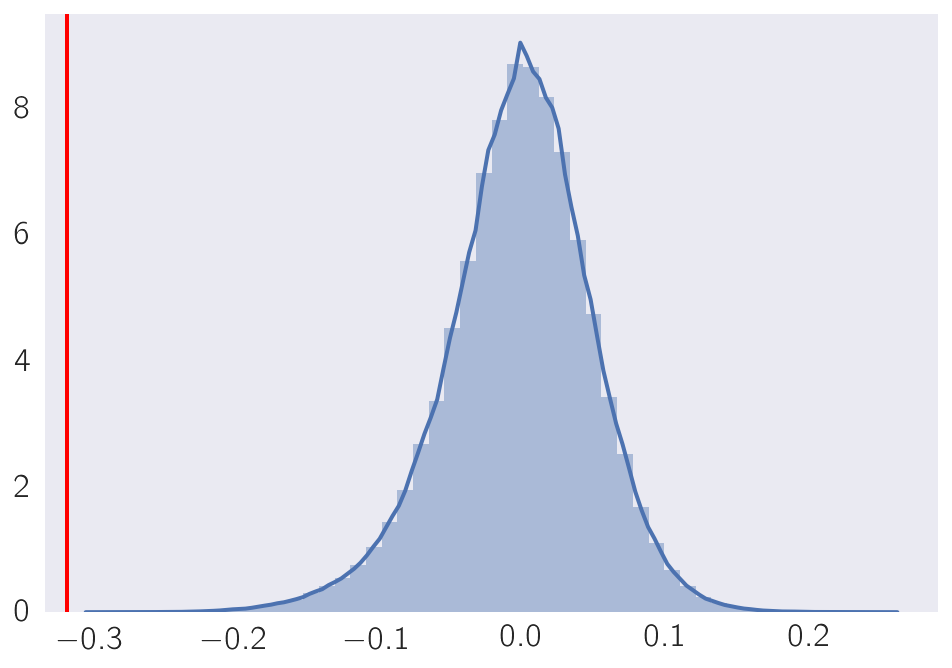

In [11]:
alpha = 10**-3  # statistical significance threshold
statistic = np.median  # statistic to use for testing

x = temp[temp['phenotypic class'] == 'bx93 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 associated'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=statistic)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red')

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)

significance(pval, alpha, 'bx93 associated', 'sy622 associated')

The medians between bx93 associated and sy622 specific are statistically significantly different.
pvalue is 0


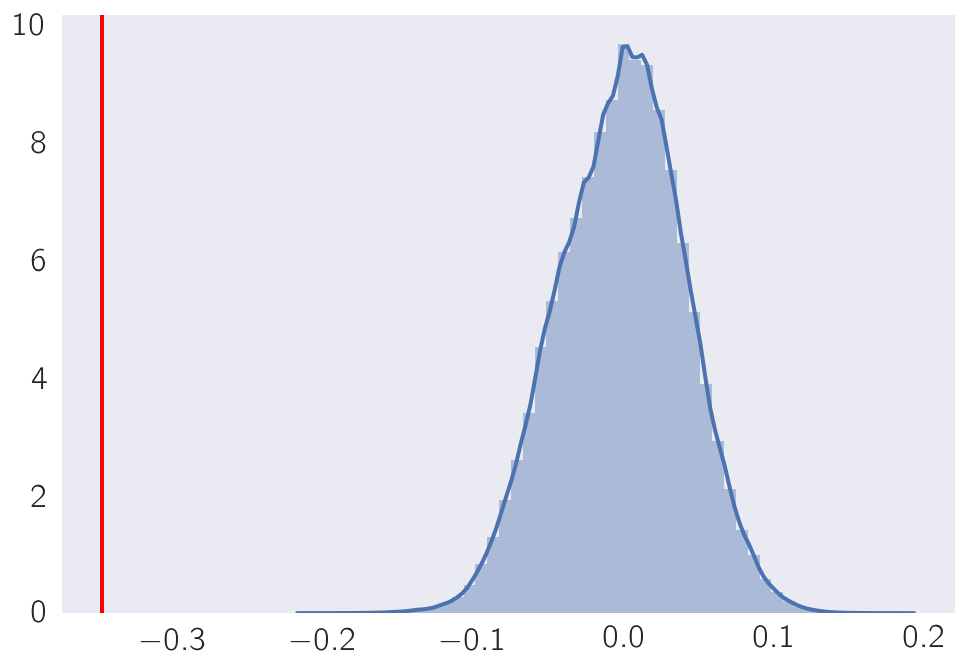

In [12]:
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=np.median)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red')

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)
significance(pval, alpha, 'bx93 associated', 'sy622 specific')

The medians between sy622 associated and sy622 specific are NOT statistically significantly different.
pvalue is 0.15


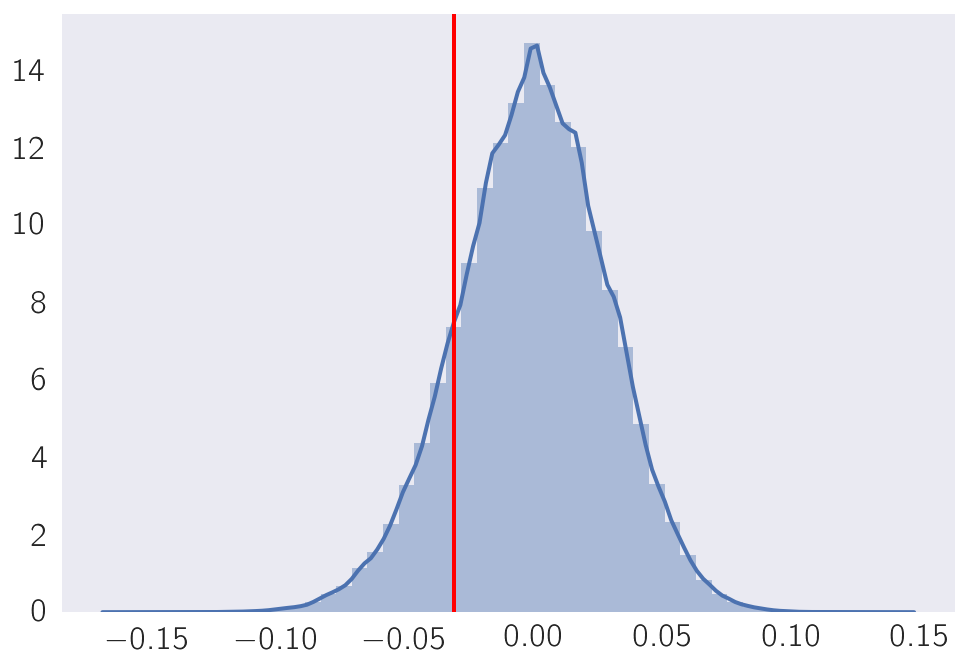

In [13]:
x = temp[temp['phenotypic class'] == 'sy622 associated'].b.values
y = temp[temp['phenotypic class'] == 'sy622 specific'].b.values

delta = bootstrap_difference_of_statistic(x, y, n=10**6, statistic=np.median)

sns.distplot(delta)
plt.axvline(statistic(y) - statistic(x), color='red')

pval = len(delta[delta < statistic(y) - statistic(x)])/len(delta)
significance(pval, alpha, 'sy622 associated', 'sy622 specific')

In [14]:
tidy.drop(['Unnamed: 0', 'absb', 'order'], axis=1).to_csv('../output/dpy_22_results.csv')